## Import Library

---

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import difflib

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, roc_auc_score

## Get Data

---

In [2]:
# get csv files of player stats and salary
salary_df = pd.read_csv('nba_salary_Mayer.csv')
player_df = pd.read_csv('nba_player_stats_Mayer.csv')

In [3]:
# convert year by taking first 4 char of year feature
# i.e. 2019-20 will be 2019 now
player_df['year'] = player_df['year'].apply(lambda x: x[:4]).astype(int)

# convert year by subtracting year by 2
# i.e. 2020 will be 2018 now
salary_df['year'] = salary_df['year'].apply(lambda x: x - 2).astype(int)

In [4]:
# get close match for each name in salary dataframe with player dataframe
player_name = player_df['PLAYER_NAME'].unique()
salary_df['name_close_match'] = salary_df['NAME'].apply(
    lambda x: (difflib.get_close_matches(x, player_name)[:1] or [None])[0])

In [5]:
# inner join salary and player stats by player name and year
df = player_df.merge(salary_df, how = 'inner', 
                     left_on=['PLAYER_NAME','year'], right_on = ['name_close_match','year'])

In [6]:
# get data shape
df.shape

(7926, 71)

## EDA

---

In [7]:
# get stats of salary
df.SALARY.describe()

count    7.926000e+03
mean     5.403477e+06
std      5.944172e+06
min      4.533000e+03
25%      1.349383e+06
50%      3.150000e+06
75%      7.300000e+06
max      4.023176e+07
Name: SALARY, dtype: float64

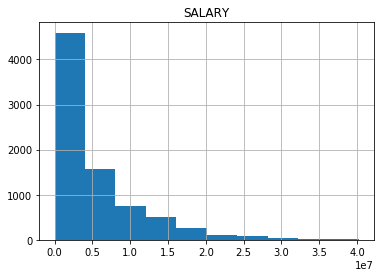

In [8]:
# plot the salary distribution
_ = df.hist('SALARY')

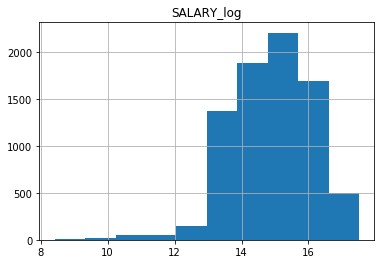

In [9]:
# take log transformation for salary
df['SALARY_log'] = np.log(df['SALARY'])

# plot the log salary distribution
_ = df.hist('SALARY_log')

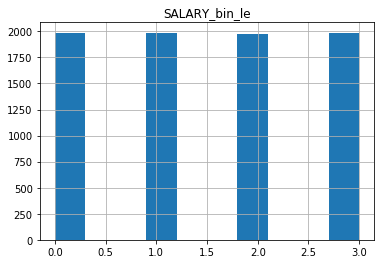

In [10]:
# divide up the salary data into 4 equal sized bins
df['SALARY_bin'] = pd.qcut(df['SALARY'], q = 4)

# encode interval to integers from 0 to 3
le = LabelEncoder()
df['SALARY_bin_le'] = le.fit_transform(df['SALARY_bin'])

# plot the bin salary distribution
_ = df.hist('SALARY_bin_le')

In [11]:
# split features and raw target
X = df[[
    'GP', 'MIN', 'FG_PCT', 'FGM', 'FGA', 'FG3M', 'FG3A',
    'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 
    'REB', 'AST', 'BLK', 'STL', 'PF', 'TOV', 'PTS']]
y = df['SALARY']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
    test_size = 0.25, random_state = 57)

In [12]:
# split features and log salary
X = df[[
    'GP', 'MIN', 'FG_PCT', 'FGM', 'FGA', 'FG3M', 'FG3A',
    'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 
    'REB', 'AST', 'BLK', 'STL', 'PF', 'TOV', 'PTS']]
y = df['SALARY_log']

# train test split for log salary
X_log_train, X_log_test, y_log_train, y_log_test = train_test_split(X, y, 
    test_size = 0.25, random_state = 57)

In [13]:
# split features and bin salary
X = df[[
    'GP', 'MIN', 'FG_PCT', 'FGM', 'FGA', 'FG3M', 'FG3A',
    'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 
    'REB', 'AST', 'BLK', 'STL', 'PF', 'TOV', 'PTS']]
y = df['SALARY_bin_le']

# train test split for log salary
X_bin_train, X_bin_test, y_bin_train, y_bin_test = train_test_split(X, y, 
    test_size = 0.25, random_state = 57)

## Model

---

###### Linear Regression

In [14]:
X_const = sm.add_constant(X_train)
model = sm.OLS(y_train, X_const)
res = model.fit()
pred = res.predict(sm.add_constant(X_test))
print('Mean Absolute Error is ', mean_absolute_error(y_test, pred))
print('\nResult Summary:')
_ = print(res.summary2())

Mean Absolute Error is  2843309.461668926

Result Summary:
                       Results: Ordinary least squares
Model:                 OLS                 Adj. R-squared:        0.495      
Dependent Variable:    SALARY              AIC:                   198138.1190
Date:                  2020-11-12 16:14    BIC:                   198278.6119
No. Observations:      5944                Log-Likelihood:        -99048.    
Df Model:              20                  F-statistic:           292.3      
Df Residuals:          5923                Prob (F-statistic):    0.00       
R-squared:             0.497               Scale:                 1.7491e+13 
-----------------------------------------------------------------------------
            Coef.       Std.Err.      t    P>|t|      [0.025        0.975]   
-----------------------------------------------------------------------------
const    2507970.4068  513535.8918  4.8837 0.0000  1501252.8322  3514687.9814
GP        -11704.5644    322

/Users/yangzibin/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


###### Linear Regression - Log Transformation

In [15]:
X_const = sm.add_constant(X_log_train)
model = sm.OLS(y_log_train, X_const)
res = model.fit()
pred = res.predict(sm.add_constant(X_log_test))
print('Mean Absolute Error is ', mean_absolute_error(np.e**y_log_test, np.e**pred))
print('\nResult Summary:')
_ = print(res.summary2())

Mean Absolute Error is  2774774.0400867644

Result Summary:
                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.428     
Dependent Variable: SALARY_log       AIC:                15553.1299
Date:               2020-11-12 16:14 BIC:                15693.6228
No. Observations:   5944             Log-Likelihood:     -7755.6   
Df Model:           20               F-statistic:        223.3     
Df Residuals:       5923             Prob (F-statistic): 0.00      
R-squared:          0.430            Scale:              0.79868   
---------------------------------------------------------------------
            Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
---------------------------------------------------------------------
const      13.5312     0.1097   123.3086   0.0000   13.3161   13.7464
GP          0.0031     0.0007     4.4973   0.0000    0.0018    0.0045
MIN         0.0206     0.0042     4.9620   0.0000    0.0125    0

/Users/yangzibin/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


###### Random Forest

In [18]:
# cross validation for logistic regression
def rf_cv(X_tr, y_tr, X_te, y_te, n_splits = 10, n = 100):

    # define kfold and loop through each iteration
    kf = KFold(n_splits = n_splits, shuffle = True, random_state = 57)

    # out of fold empty array
    oof = np.zeros(shape = (X_tr.shape[0]))
    # folds empty array
    folds = np.zeros(shape = (X_tr.shape[0]))
    # test empty array
    t_fold = np.zeros(shape = (X_te.shape[0]))

    # initial train, test and validation MAE
    mae_train = []
    mae_valid = []
    mae_test = []
    
    for ti, vi in kf.split(X_tr):
        
        # split train and valid dataframe
        train_features, train_labels = X_tr.loc[ti], y_tr[ti]
        valid_features, valid_labels = X_tr.loc[vi], y_tr[vi]

        rf = RandomForestRegressor(n_estimators = n, max_depth = 10, random_state = 57)
        rf.fit(train_features, train_labels)
        
        oof[vi] = rf.predict(valid_features)
        folds[ti] = rf.predict(train_features)
        t_fold += rf.predict(X_te)
        
        # update MAE score for train and validation
        mae_train.append(mean_absolute_error(train_labels, folds[ti]))
        mae_valid.append(mean_absolute_error(valid_labels, oof[vi]))
    
    # update MAE score for test
    mae_test.append(mean_absolute_error(y_te, np.round(t_fold / n_splits)))
    
    return mae_train, mae_valid, mae_test

In [19]:
# grid search for best model based on MAE score
mae_train_list = []
mae_valid_list = []
mae_test_list = []
N = []
X_train.reset_index(drop = True, inplace = True)
for n in [50, 100, 150, 200]:
    mae_train, mae_valid, mae_test = rf_cv(X_train,  y_train.values, X_test, y_test.values, n_splits = 5, n = n)
    N.append(n)
    mae_train_list.append(np.mean(mae_train))
    mae_valid_list.append(np.mean(mae_valid))
    mae_test_list.append(mae_test)
    
print('Best Model:')
print('N = ', N[mae_valid_list.index(np.max(mae_valid_list))])
print('Validation MAE: ', mae_valid_list[mae_valid_list.index(np.max(mae_valid_list))])
print('Testing MAE: ', mae_test_list[mae_valid_list.index(np.max(mae_valid_list))])

Best Model:
N =  50
Validation MAE:  2751807.803611836
Testing MAE:  [2729322.5055499496]


###### Random Forest - Log Transformation

In [20]:
# cross validation for logistic regression
def rf_log_cv(X_tr, y_tr, X_te, y_te, n_splits = 10, n = 100):

    # define kfold and loop through each iteration
    kf = KFold(n_splits = n_splits, shuffle = True, random_state = 57)

    # out of fold empty array
    oof = np.zeros(shape = (X_tr.shape[0]))
    # folds empty array
    folds = np.zeros(shape = (X_tr.shape[0]))
    # test empty array
    t_fold = np.zeros(shape = (X_te.shape[0]))

    # initial train, test and validation MAE
    mae_train = []
    mae_valid = []
    mae_test = []
    
    for ti, vi in kf.split(X_tr):
        
        # split train and valid dataframe
        train_features, train_labels = X_tr.loc[ti], y_tr[ti]
        valid_features, valid_labels = X_tr.loc[vi], y_tr[vi]

        rf = RandomForestRegressor(n_estimators = n, max_depth = 10, random_state = 57)
        rf.fit(train_features, train_labels)
        
        oof[vi] = rf.predict(valid_features)
        folds[ti] = rf.predict(train_features)
        t_fold += rf.predict(X_te)
        
        # update MAE score for train and validation
        mae_train.append(mean_absolute_error(np.e**train_labels, np.e**folds[ti]))
        mae_valid.append(mean_absolute_error(np.e**valid_labels, np.e**oof[vi]))
    
    # update MAE score for test
    mae_test.append(mean_absolute_error(np.e**y_te, np.e**(np.round(t_fold / n_splits))))
    
    return mae_train, mae_valid, mae_test

In [21]:
# grid search for best model based on MAE score
mae_train_list = []
mae_valid_list = []
mae_test_list = []
N = []
X_log_train.reset_index(drop = True, inplace = True)
for n in [50, 100, 150, 200]:
    mae_train, mae_valid, mae_test = rf_log_cv(X_log_train,  y_log_train.values, X_log_test, y_log_test.values, n_splits = 5, n = n)
    N.append(n)
    mae_train_list.append(np.mean(mae_train))
    mae_valid_list.append(np.mean(mae_valid))
    mae_test_list.append(mae_test)

print('Best Model:')
print('N = ', N[mae_valid_list.index(np.max(mae_valid_list))])
print('Validation MAE: ', mae_valid_list[mae_valid_list.index(np.max(mae_valid_list))])
print('Testing MAE: ', mae_test_list[mae_valid_list.index(np.max(mae_valid_list))])

Best Model:
N =  50
Validation MAE:  2736949.0007144
Testing MAE:  [2911965.5297269295]


###### Random Forest - Bin Salary

In [22]:
# cross validation for logistic regression
def rf_bin_cv(X_tr, y_tr, X_te, y_te, n_splits = 10, n = 100):

    # define kfold and loop through each iteration
    kf = KFold(n_splits = n_splits, shuffle = True, random_state = 57)

    # out of fold empty array
    oof = np.zeros(shape = (X_tr.shape[0]))
    # folds empty array
    folds = np.zeros(shape = (X_tr.shape[0]))
    # test empty array
    t_fold = np.zeros(shape = (X_te.shape[0]))

    # initial train, test and validation accuracy
    acc_train = []
    acc_valid = []
    acc_test = []
    
    for ti, vi in kf.split(X_tr):
        
        # split train and valid dataframe
        train_features, train_labels = X_tr.loc[ti], y_tr[ti]
        valid_features, valid_labels = X_tr.loc[vi], y_tr[vi]

        rf = RandomForestClassifier(n_estimators = n, max_depth = 10, random_state = 57)
        rf.fit(train_features, train_labels)
        
        oof[vi] = rf.predict(valid_features)
        folds[ti] = rf.predict(train_features)
        t_fold += rf.predict(X_te)
        
        # update accuracy score for train and validation
        acc_train.append(accuracy_score(train_labels, folds[ti]))
        acc_valid.append(accuracy_score(valid_labels, oof[vi]))
    
    # update accuracy score for test
    acc_test.append(accuracy_score(y_te, np.round(t_fold / n_splits)))
    
    return acc_train, acc_valid, acc_test

In [23]:
# grid search for best model based on Accuracy score
acc_train_list = []
acc_valid_list = []
acc_test_list = []
N = []
X_bin_train.reset_index(drop = True, inplace = True)
for n in [50, 100, 150, 200]:
    acc_train, acc_valid, acc_test = rf_bin_cv(X_bin_train,  y_bin_train.values, X_bin_test, y_bin_test.values, n_splits = 5, n = n)
    N.append(n)
    acc_train_list.append(np.mean(acc_train))
    acc_valid_list.append(np.mean(acc_valid))
    acc_test_list.append(acc_test)

print('Best Model:')
print('N = ', N[acc_valid_list.index(np.max(acc_valid_list))])
print('Validation Accuracy: ', acc_valid_list[acc_valid_list.index(np.max(acc_valid_list))])
print('Testing Accuracy: ', acc_test_list[acc_valid_list.index(np.max(acc_valid_list))])


Best Model:
N =  100
Validation Accuracy:  0.5102638382705666
Testing Accuracy:  [0.5418768920282543]


## Feature Importance

---

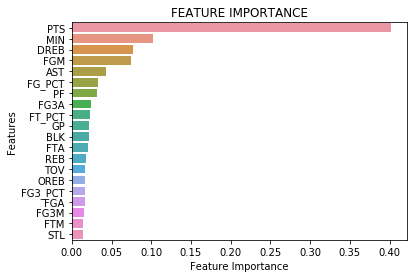

In [42]:
# select the best performance model
rf = RandomForestRegressor(n_estimators = 50, max_depth = 10, random_state = 57)
rf.fit(X_train,  y_train.values)

# dataframe for feature importance and feature names
feature_importance = np.array(rf.feature_importances_)
features = np.array(X_train.columns)
fi_df = pd.DataFrame({'features':features,'feature_importance':feature_importance})

# sort the dataframe by feature importance
fi_df.sort_values(by=['feature_importance'], ascending = False , inplace = True)


# plot bar chart
sns.barplot(fi_df['feature_importance'], fi_df['features'])
plt.title('FEATURE IMPORTANCE')
plt.xlabel('Feature Importance')
_ = plt.ylabel('Features')

The top three important features are points per game, minutes played per game and defensive rebounds per game.

### useless code

###### Avg Player Age vs Season

In [ ]:
player_seasonAvg = player_df.groupby('season').mean()

fig, ax = plt.subplots(figsize = (10, 6), facecolor='w')
g = sns.lineplot(player_seasonAvg.index, player_seasonAvg['AGE'])
_ = g.set_title('Average Player Age vs Season')
_ = g.set_xticklabels(player_seasonAvg.index, rotation=30)

In [ ]:
player_df['name_season'] = player_df['PLAYER_NAME'] + '_' + player_df['season']

In [ ]:
player_df['PTS_PER_MIN'] = player_df['PTS']/player_df['MIN']
player_df_pts = player_df.sort_values(by='PTS_PER_MIN')

In [ ]:
fig, ax = plt.subplots(figsize = (13, 6), facecolor='w')
g = sns.barplot(player_df_pts['name_season'][-20:], player_df_pts['PTS_PER_MIN'][-20:])
_ = g.set_title('Top 20 Players by Points per Minute')
_ = g.set_xticklabels(player_df_pts['name_season'][-20:], rotation = 90)

In [ ]:
player_df_pts = player_df.sort_values(by='PTS')

fig, ax = plt.subplots(figsize = (13, 6), facecolor='w')
g = sns.barplot(player_df_pts['name_season'][-20:], player_df_pts['PTS'][-20:])
_ = g.set_title('Top 20 Players by Points')
_ = g.set_xticklabels(player_df_pts['name_season'][-20:], rotation = 90)

In [ ]:
# select James Harden, Kobe Bryant and Allen Iverson
player_df_top3 = player_df.loc[(player_df['PLAYER_NAME'] == 'James Harden')
                               | (player_df['PLAYER_NAME'] == 'Kobe Bryant')
                               | (player_df['PLAYER_NAME'] == 'Allen Iverson')]

In [ ]:
player_df_top3 = player_df_top3.sort_values(by='name_season')

In [ ]:
fig, ax = plt.subplots(figsize = (13, 6), facecolor='w')
g = sns.lineplot(player_df_top3['season'], player_df_top3['PTS'], 
                    hue = player_df_top3['PLAYER_NAME'])
_ = g.set_xticklabels(player_df_top3['season'], rotation = 90)

In [ ]:
salary_df = player_salary(2020)
salary_df['NAME'] = salary_df['NAME'].apply(lambda x: x.split(',')[0])

In [ ]:

player_df_2020 = player_df.loc[player_df['season'] == '2019-20']

In [ ]:
player_df_2020 = player_df_2020.merge(salary_df, on = 'PLAYER_NAME', how = 'left')

In [ ]:
player_df_2020.dropna(axis = 0, inplace = True)
player_df_2020.reset_index(inplace = True)

In [ ]:
X_train = player_df_2020[['PTS', 'AGE', 'GP', 'MIN', 'W', 'L', 'FGM', 'FGA', 
               'FG_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 
               'BLK', 'BLKA', 'PF']]
y_train = player_df_2020['SALARY'].replace('[\$,]', '', regex=True).astype(float)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [ ]:
import lightgbm
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_estimators = 50, random_state=0)
regr.fit(X_train, y_train)

In [ ]:
pred = regr.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_squared_error(y_test, pred)

In [ ]:
mean_absolute_error(y_test, pred)

In [ ]:
pred = regr.predict(X_train)
mean_squared_error(y_train, pred)

In [ ]:
mean_absolute_error(y_train, pred)

In [ ]:
team_df = nba_team_data('2019-20')

In [ ]:
team_df.head()

In [ ]:
# get team name and abbrecivation dataframe
team_name_url = 'https://en.wikipedia.org/wiki/Wikipedia:WikiProject_National_Basketball_Association/National_Basketball_Association_team_abbreviations'
team_name = pd.read_html(team_name_url)
team_name = team_name[0][1:]
team_name.columns = ['TEAM_ABBREVIATION', 'TEAM_NAME']

In [ ]:
# add team name feature to player_df
player_df = player_df.merge(team_name, on = 'TEAM_ABBREVIATION', how = 'left')

# select TEAM_NAME and W_PCT from team_df
team_df_wPCT = team_df[['TEAM_NAME', 'W_PCT']]

# team_df_wPCT left join player_df
player_df['TEAM_NAME'] = player_df['TEAM_NAME'].replace(['Los Angeles Clippers'], 'LA Clippers')
df = team_df_wPCT.merge(player_df, on = 'TEAM_NAME', how = 'left')

In [ ]:
# train = df.groupby('TEAM_NAME').mean()
# train.reset_index(level=0, inplace=True)

In [ ]:
from sklearn.cluster import KMeans
X = player_df[['AGE', 'GP', 'MIN', 'W', 'L', 'PTS', 'FGM', 'FGA', 
               'FG_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 
               'BLK', 'BLKA', 'PF']]
kmeans = KMeans(n_clusters = 5, random_state = 0).fit(X)

In [ ]:
labels = pd.DataFrame({'label': kmeans.labels_})

In [ ]:
player_df = pd.concat([player_df, labels], axis = 1)

In [ ]:
df = team_df_wPCT.merge(player_df, on = 'TEAM_NAME', how = 'left')

In [ ]:
a = df.groupby('TEAM_NAME').mean()

In [ ]:
a = a[['W_PCT_x', 'label']]

In [ ]:
a.corr()